In [1]:
# We import needed packages

import numba as nb
import numpy as np

from pde import PDE, FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid, CartesianGrid, MemoryStorage, plot_kymograph, movie # Coming from py-pde, which is not the same than pypde!!!

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

The equations to solve in an expanded way are the following:

$$
\frac{\partial\rho}{\partial t}+u\frac{\partial\rho}{\partial x}+\rho\frac{\partial u}{\partial x}=0
$$

$$
\rho\left(\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}\right)+\frac{\partial p}{\partial x}=0
$$

$$
\frac{\partial p}{\partial t}+\gamma p\frac{\partial u}{\partial x}+\frac{\partial p}{\partial x}=0
$$

Where $\rho$, $p$ and $u$ are the density, pressure and velocity of the classical fluid, respectively, and $\gamma=1.4$ corresponds to the heat capacity ratio.
The spatial dimension $x$ is partitioned in 400 discretized parts from 0 to 1, while $t$ is discretized from 0 to $t_{f}=0.2$ with $nt=400$.

The initial conditions ($t=0$) are written as follows:

$$ \text{Initial conditions ($t=0$)}=  \left\{
\begin{array}{ll}
      \rho=1 & \text{for all $x$} \\
      p=1 & \text{if $x\leq 0.5$ and $p=10$ else} \\
      u=0.9 & \text{if $x\leq 0.5$ and $u=0$ else} \\
\end{array} 
\right. $$ 

In [2]:
nx = 1000 # Number of partitions in space
nt = 1000 # Number of partitions in time
tf = 0.2 # Final time
xf = 1 # Final point
dt = tf/nt # Temporal interval
gamma = 1.4 # Heat capacity ratio

# We define functional equations.

eq = PDE(
    {
        "rho": f"-u * get_x(gradient(rho)) - rho * get_x(gradient(u))",
        "p": f"-{gamma} * p * get_x(gradient(u)) - get_x(gradient(p))",
        "u": f"-(1/rho) * get_x(gradient(p)) - u * get_x(gradient(u))",
    },
    user_funcs={"get_x": lambda arr: arr[0]},
)

In [3]:
# We try to solve:

# Initial state (Initial conditions, t = 0):

x = np.linspace(0, xf, nx)

ic_rho = lambda x : 1
ic_p = lambda x: 1*(x<=0.5) + 10*(x>0.5)
ic_u = lambda x: 0.9*(x<=0.5)

# Defining grid:
grid = UnitGrid([nx])
#grid = CartesianGrid([[0, xf]], [nx], periodic = False) # The cartesian grid seems to not work with systems of equations...

rho = ScalarField(grid, ic_rho(x))
p = ScalarField(grid, ic_p(x))
u = ScalarField(grid, ic_u(x))

# Defining state
state = FieldCollection([rho, p, u])

# Simulation
storage = MemoryStorage()
sol = eq.solve(state, t_range = tf, dt = dt, tracker = ["progress", storage.tracker(dt)])

  0%|          | 0/0.2 [00:00<?, ?it/s]

In [4]:
# We export the evolution in time of the variables:

times = []
rho_evolved = []
p_evolved = []
u_evolved = []

for time, field in storage.items():
    times.append(time)
    rho_evolved.append(field[0].data)
    p_evolved.append(field[1].data)
    u_evolved.append(field[2].data)

times = np.array(times) # Shape (nt,)
rho_evolved = np.array(rho_evolved) # Shape (nt, nx)
p_evolved = np.array(p_evolved) # Shape (nt, nx)
u_evolved = np.array(u_evolved) # Shape (nt, nx)

In [5]:
# Let's try to make some 3D plots...

X, T = np.meshgrid(x, times)

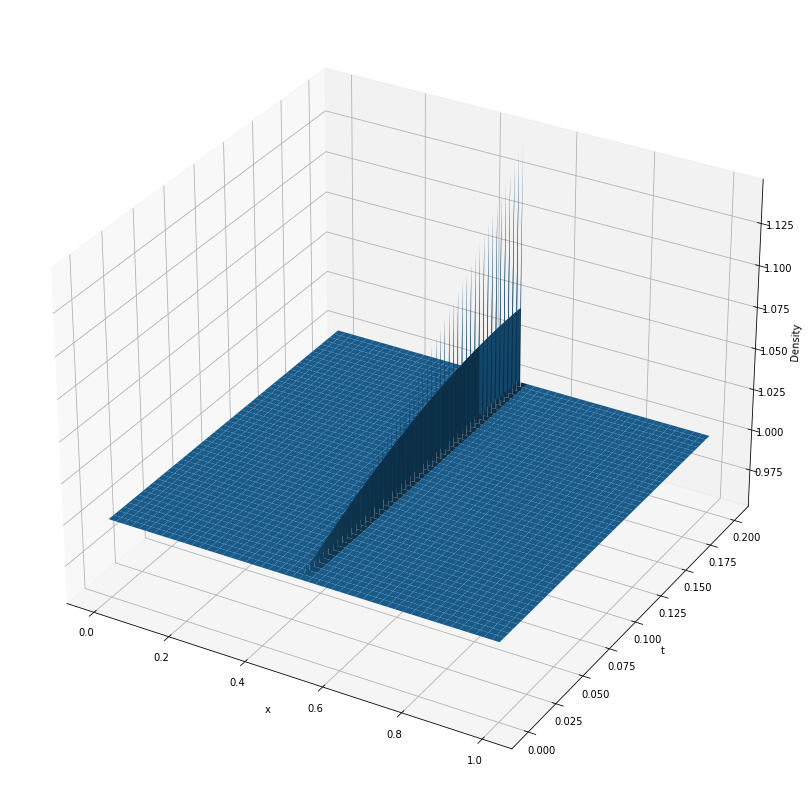

In [6]:
fig = plt.figure()
fig.set_size_inches(19, 11)
ax = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(ax)
ax.plot_surface(X, T, rho_evolved)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Density")
plt.show()

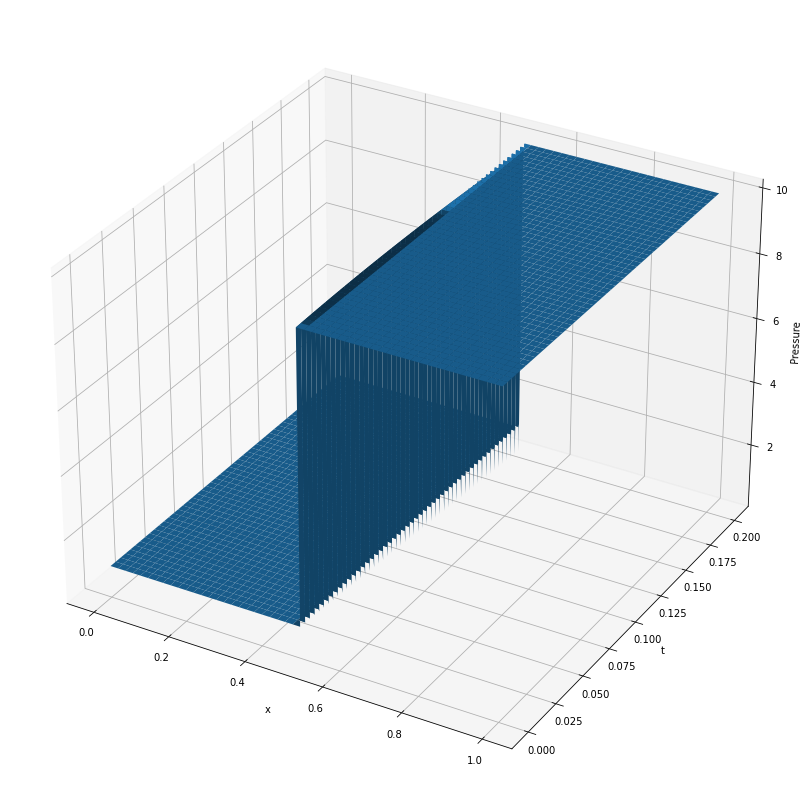

In [7]:
fig = plt.figure()
fig.set_size_inches(19, 11)
ax = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(ax)
ax.plot_surface(X, T, p_evolved)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Pressure")
plt.show()

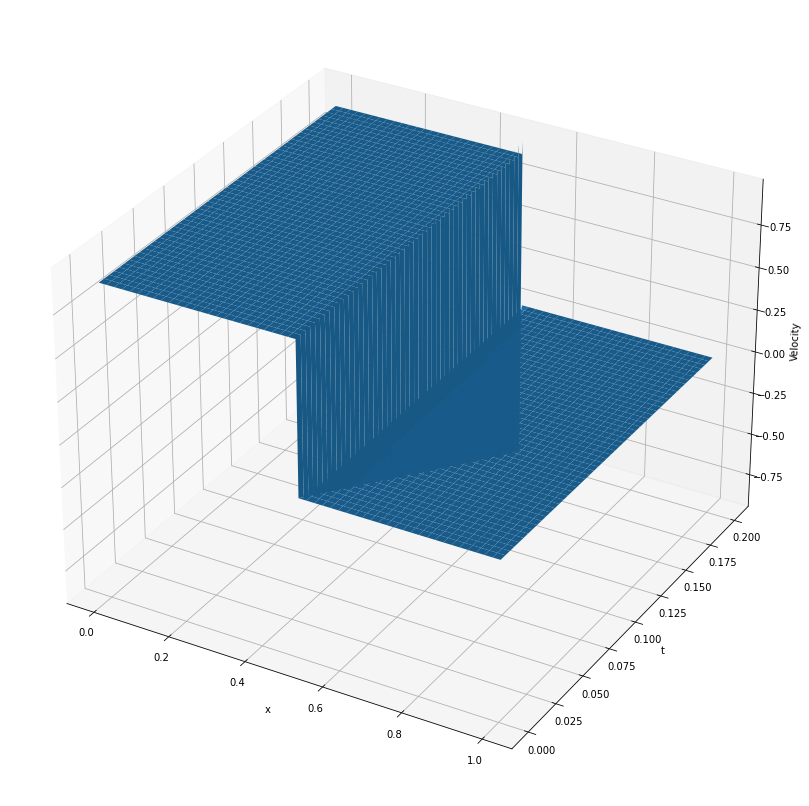

In [8]:
fig = plt.figure()
fig.set_size_inches(19, 11)
ax = Axes3D(fig, auto_add_to_figure = False)
fig.add_axes(ax)
ax.plot_surface(X, T, u_evolved)
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("Velocity")
plt.show()